<br>
<font size=8 color='blue' face='Candara'>
    <center>
        <b>Tracking COVID-19 Around the World</b>
    </center>
</font>
<br>

In [1]:
%reset -f

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import numpy as np
import pandas as pd

from collections import Counter

import re

from ipywidgets import interact, interactive, widgets
from IPython.display import display

from colorama import Style, Fore, Back

In [3]:
daysOfWeek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
monthsOfYear = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

def getFullDate(dtm):
    wkdy = daysOfWeek[dtm.dayofweek][:3]
    mth = monthsOfYear[dtm.month - 1]
    dy = str(dtm.day)
    if len(dy)==1:
        dy = '0'+dy
    yr = str(dtm.year)
    return (wkdy+', '+mth+' '+dy+' '+yr)

## Load Datasets

In [4]:
# load datasets from remote repo

urlGlobalConf = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
urlGlobalDeaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
urlGlobalRecovery = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

dfConfGlobal = pd.read_csv(urlGlobalConf)
dfDeadGlobal = pd.read_csv(urlGlobalDeaths)
dfRecGlobal = pd.read_csv(urlGlobalRecovery)

dfConfGlobal.to_csv('TimeSeriesConfirmedGlobal.csv')
dfDeadGlobal.to_csv('TimeSeriesDeadGlobal.csv')
dfRecGlobal.to_csv('TimeSeriesRecoveredGlobal.csv')

theDatesGlobal = re.findall(pattern='[0-9]{1,2}/[0-9]{1,2}/[0-9]{1,4}', string=str(list(dfConfGlobal.columns)))

# =======================================================================================================================

urlConfUS = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
urlDeathsUS = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'

dfConfUS = pd.read_csv(urlConfUS)
dfDeadUS = pd.read_csv(urlDeathsUS)

dfConfUS.to_csv('TimeSeriesConfirmedUS.csv')
dfDeadUS.to_csv('TimeSeriesDeadUS.csv')

theDatesUS = re.findall(pattern='[0-9]{1,2}/[0-9]{1,2}/[0-9]{1,4}', string=str(list(dfConfUS.columns)))

In [5]:
# # load locally saved datasets if remote repo is unavailable

# dfConfGlobal = pd.read_csv('TimeSeriesConfirmedGlobal.csv')
# dfDeadGlobal = pd.read_csv('TimeSeriesDeadGlobal.csv')
# dfRecGlobal = pd.read_csv('TimeSeriesRecoveredGlobal.csv')

# theDatesGlobal = re.findall(pattern='[0-9]{1,2}/[0-9]{1,2}/[0-9]{1,4}', string=str(list(dfConfGlobal.columns)))

# # =====================================================================================================================

# dfConfUS = pd.read_csv('TimeSeriesConfirmedUS.csv')
# dfDeadUS = pd.read_csv('TimeSeriesDeadUS.csv')

# theDatesUS = re.findall(pattern='[0-9]{1,2}/[0-9]{1,2}/[0-9]{1,4}', string=str(list(dfConfUS.columns)))

## Summary from Latest Global Data

In [6]:
def getCountrySummary_New(Country):
    
    idx = [True if i==Country else False for i in dfConfGlobal['Country/Region']]
    cdf = dfConfGlobal[idx]

    idx = [True if i==Country else False for i in dfDeadGlobal['Country/Region']]
    ddf = dfDeadGlobal[idx]

    idx = [True if i==Country else False for i in dfRecGlobal['Country/Region']]
    rdf = dfRecGlobal[idx]

    cc = cdf[theDatesGlobal[-1]].sum()
    dd = ddf[theDatesGlobal[-1]].sum()
    rr = rdf[theDatesGlobal[-1]].sum()
    
    print('Figures at a Glance (' + Country + ')\n\tConfirmed:\t', cc, '\n\tDeaths:\t\t', dd, '\n\tRecovered:\t', rr)

# ====================================================================================

summaryCountryList = sorted(list(set(dfConfGlobal['Country/Region'])))

interact(getCountrySummary_New, Country=summaryCountryList);

interactive(children=(Dropdown(description='Country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

In [7]:
def getCountryTotals_New(Sort_By):
    res = []
    for cntry in set(dfConfGlobal['Country/Region']):
        
        idx = [True if i==cntry else False for i in dfConfGlobal['Country/Region']]
        cdf = dfConfGlobal[idx]
        
        idx = [True if i==cntry else False for i in dfDeadGlobal['Country/Region']]
        ddf = dfDeadGlobal[idx]
        
        idx = [True if i==cntry else False for i in dfRecGlobal['Country/Region']]
        rdf = dfRecGlobal[idx]
        
        cc = cdf[theDatesGlobal[-1]].sum()
        dd = ddf[theDatesGlobal[-1]].sum()
        rr = rdf[theDatesGlobal[-1]].sum()
        deathRate = round(dd/cc, 2)
        recoveryRate = round(rr/cc, 2)
        
        res.append( (cntry, cc, dd, rr, deathRate, recoveryRate) )
        
    sorter = {'Confirmed': 1, 'Deaths': 2, 'Recoveries': 3, 'Death_Rate': 4, 'Recovery_Rate': 5}
    res = sorted(res, key=lambda x:x[sorter[Sort_By]], reverse=True)
    return pd.DataFrame(res, columns=['Country', 'Confirmed', 'Deaths', 'Recoveries', 'Death_Rate', 'Recovery_Rate']).head(26)

# ==================================================================

sortList = ['Confirmed', 'Deaths', 'Recoveries', 'Death_Rate', 'Recovery_Rate']

interact(getCountryTotals_New, Sort_By=sortList);

interactive(children=(Dropdown(description='Sort_By', options=('Confirmed', 'Deaths', 'Recoveries', 'Death_Rat…

## Global COVID Data

In [8]:
# function to plot the country-level outcomes (cases/deaths/recoveries)

def plotGlobalOutcome(thisCountry, thisOutcome='cases'):
    
    if thisOutcome=='death':
        idx = [True if (i==thisCountry) else False for i in dfDeadGlobal['Country/Region']]
        df = dfDeadGlobal[idx]
        theOutcome = 'Deaths'
        theColor = 'red'
    elif thisOutcome=='recovery':
        idx = [True if (i==thisCountry) else False for i in dfRecGlobal['Country/Region']]
        df = dfRecGlobal[idx]
        theOutcome = 'Recoveries'
        theColor = 'C0'
    else:
        idx = [True if (i==thisCountry) else False for i in dfConfGlobal['Country/Region']]
        df = dfConfGlobal[idx]
        theOutcome = 'Cases'
        theColor = 'C1'

    res = []

    for i in theDatesGlobal:
        ss = df[i].sum()
        res.append( (i, ss) )

    theCountry = list(set(df['Country/Region']))[0]

    px = [i[0] for i in res]
    py = [i[1] for i in res]
    
    tks = list(range(len(px)))[-1::-5][-1::-1]
    lbls = [getFullDate(i) for i in pd.to_datetime(px[-1::-5][-1::-1])]

    plt.figure(figsize=[22,10])
    plt.bar(px,py, color=theColor)
    plt.xticks(ticks=tks, labels=lbls, fontsize=15, rotation=90)
    plt.yticks(fontsize=25, rotation=0)
    plt.ylabel('# '+theOutcome, fontsize=30)
    plt.title('Confirmed ' + theOutcome + ' in ' + theCountry, fontsize=35)
    plt.show()

In [9]:
# function to plot the country-level curves (active cases)

def plotCurveGlobal(thisCountry):
    
    idx = [True if i==thisCountry else False for i in dfConfGlobal['Country/Region']]
    cdf = dfConfGlobal[idx]
    
    idx = [True if i==thisCountry else False for i in dfDeadGlobal['Country/Region']]
    ddf = dfDeadGlobal[idx]
    
    idx = [True if i==thisCountry else False for i in dfRecGlobal['Country/Region']]
    rdf = dfRecGlobal[idx]

    res = []

    for dt in theDatesGlobal:
        ss = cdf[dt].sum() - ddf[dt].sum() - rdf[dt].sum()
        res.append( (dt, ss) )

    theCountry = list(set(cdf['Country/Region']))[0]

    px = [i[0] for i in res]
    py = [i[1] for i in res]
    
    tks = list(range(len(px)))[-1::-5][-1::-1]
    lbls = [getFullDate(i) for i in pd.to_datetime(px[-1::-5][-1::-1])]

    plt.figure(figsize=[22,10])
    plt.bar(px,py, color='C4')
    plt.xticks(ticks=tks, labels=lbls, fontsize=15, rotation=90)
    plt.yticks(fontsize=25, rotation=0)
    plt.ylabel('# Active Cases', fontsize=30)
    plt.title('Active Cases in ' + theCountry, fontsize=35)
    plt.show()

In [10]:
def showCountry(Country):
    plotGlobalOutcome(Country)
    plotGlobalOutcome(Country, 'death')
    plotGlobalOutcome(Country, 'recovery')

theCountryList = sorted(list(set(dfRecGlobal['Country/Region'])))

interact(showCountry, Country=theCountryList);

interactive(children=(Dropdown(description='Country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

In [11]:
def showCurve(Country):
    plotCurveGlobal(Country)

theCountryList = sorted(list(set(dfRecGlobal['Country/Region'])))

interact(showCurve, Country=theCountryList);

interactive(children=(Dropdown(description='Country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

## USA COVID Data

In [12]:
# function to plot the state-level outcomes (cases/deaths)

def plotOutcome(thisState, thisOutcome='cases'):
    
    if thisOutcome=='deaths':
        idx = [True if (i==thisState) else False for i in dfDeadUS['Province_State']]
        df = dfDeadUS[idx]
        theOutcome = 'Deaths'
        theColor = 'red'
    else:
        idx = [True if (i==thisState) else False for i in dfConfUS['Province_State']]
        df = dfConfUS[idx]
        theOutcome = 'Cases'
        theColor = 'C1'

    res = []

    for i in theDatesUS:
        ss = df[i].sum()
        res.append( (i, ss) )

    px = [i[0] for i in res]
    py = [i[1] for i in res]
    
    tks = list(range(len(px)))[-1::-5][-1::-1]
    lbls = [getFullDate(i) for i in pd.to_datetime(px[-1::-5][-1::-1])]

    plt.figure(figsize=[22,10])
    plt.bar(px,py, color=theColor)
    plt.xticks(ticks=tks, labels=lbls, fontsize=15, rotation=90)
    plt.yticks(fontsize=25, rotation=0)
    plt.ylabel('# '+theOutcome, fontsize=30)
    plt.title('Confirmed ' + theOutcome + ' in ' + thisState, fontsize=35)
    plt.show()

In [13]:
theStateList = sorted(list(set(dfConfUS['Province_State'])))

def showState(State):
    plotOutcome(State, thisOutcome='cases')
    plotOutcome(State, thisOutcome='deaths')

interact(showState, State=theStateList);

interactive(children=(Dropdown(description='State', options=('Alabama', 'Alaska', 'American Samoa', 'Arizona',…

## Texas COVID Data

In [14]:
idx = [True if i=='Texas' else False for i in dfConfUS['Province_State']]
dfConfTexas = dfConfUS[idx]

idx = [True if i=='Texas' else False for i in dfDeadUS['Province_State']]
dfDeadTexas = dfDeadUS[idx]

theDatesTexas = re.findall(pattern='[0-9]{1,2}/[0-9]{1,2}/[0-9]{1,4}', string=str(list(dfConfTexas.columns)))

In [15]:
# function to plot the county-level outcomes (cases/deaths) for Texas

def plotTexasCountyOutcome(County):
    
    idx = [True if (i==County) else False for i in dfConfTexas['Admin2']]
    cdf = dfConfTexas[idx]
    
    idx = [True if (i==County) else False for i in dfDeadTexas['Admin2']]
    ddf = dfDeadTexas[idx]

    res = []

    for i in theDatesTexas:
        cc = cdf[i].sum()
        dd = ddf[i].sum()
        res.append( (i, cc, dd) )

    px = [i[0] for i in res]
    py = [i[1] for i in res]
    pz = [i[2] for i in res]
    
    tks = list(range(len(px)))[-1::-5][-1::-1]
    lbls = [getFullDate(i) for i in pd.to_datetime(px[-1::-5][-1::-1])]

    plt.figure(figsize=[22,10])
    plt.plot(px,py, color='C1', linewidth=5)
    plt.xticks(ticks=tks, labels=lbls, fontsize=15, rotation=90)
    plt.yticks(fontsize=25, rotation=0)
    plt.ylabel('# Cases', fontsize=30)
    plt.title('Confirmed Cases in ' + County.upper() + ' County', fontsize=35)
    plt.show()
    
    plt.figure(figsize=[22,10])
    plt.plot(px,pz, color='red', linewidth=5)
    plt.xticks(ticks=tks, labels=lbls, fontsize=15, rotation=90)
    plt.yticks(fontsize=25, rotation=0)
    plt.ylabel('# Deaths', fontsize=30)
    plt.title('Confirmed Deaths in ' + County.upper() + ' County', fontsize=35)
    plt.show()

In [16]:
theCountyList = sorted(list(set(dfConfTexas['Admin2'])))

interact(plotTexasCountyOutcome, County=theCountyList);

interactive(children=(Dropdown(description='County', options=('Anderson', 'Andrews', 'Angelina', 'Aransas', 'A…

## COVID Reports for States and Counties

In [17]:
xdf = dfConfUS.copy()
zdf = dfDeadUS.copy()

xdf['Admin2'] = ['Unknown_'+i[0] if i[1]!=i[1] else i[1] for i in zip(xdf['Province_State'], xdf['Admin2'])]
zdf['Admin2'] = ['Unknown_'+i[0] if i[1]!=i[1] else i[1] for i in zip(zdf['Province_State'], zdf['Admin2'])]

In [18]:
# function to plot the county-level outcomes (cases/deaths) for US States

def plotStateCountyOutcome(State, County):
    
    idx = [True if i==State else False for i in xdf['Province_State']]
    cdf = xdf[idx]
    
    idx = [True if i==State else False for i in zdf['Province_State']]
    ddf = zdf[idx]
    
    if County not in list(cdf['Admin2']):
        County = np.random.choice(cdf['Admin2'])
    
    idx = [True if (i==County) else False for i in cdf['Admin2']]
    cdf = cdf[idx]
    
    idx = [True if (i==County) else False for i in ddf['Admin2']]
    ddf = ddf[idx]

    res = []

    for i in theDatesUS:
        cc = cdf[i].sum()
        dd = ddf[i].sum()
        res.append( (i, cc, dd) )

    px = [i[0] for i in res]
    py = [i[1] for i in res]
    pz = [i[2] for i in res]
    
    tks = list(range(len(px)))[-1::-5][-1::-1]
    lbls = [getFullDate(i) for i in pd.to_datetime(px[-1::-5][-1::-1])]

    plt.figure(figsize=[22,10])
    plt.plot(px,py, color='C1', linewidth=5)
    plt.xticks(ticks=tks, labels=lbls, fontsize=15, rotation=90)
    plt.yticks(fontsize=25, rotation=0)
    plt.ylabel('# Cases', fontsize=30)
    plt.title('Confirmed Cases in ' + County.upper() + ' County, '+State.upper(), fontsize=35)
    plt.show()
    
    plt.figure(figsize=[22,10])
    plt.plot(px,pz, color='red', linewidth=5)
    plt.xticks(ticks=tks, labels=lbls, fontsize=15, rotation=90)
    plt.yticks(fontsize=25, rotation=0)
    plt.ylabel('# Deaths', fontsize=30)
    plt.title('Confirmed Deaths in ' + County.upper() + ' County, '+State.upper(), fontsize=35)
    plt.show()

In [19]:
tt = zip(dfConfUS['Province_State'], dfConfUS['Admin2'])
tt = [(i,j) if j==j else (i, 'Unknown_'+i) for i,j in tt]

dictLoc = dict()

for i in tt:
    try:
        dictLoc[i[0]].append(i[1])
    except KeyError:
        dictLoc[i[0]] = [i[1]]

In [20]:
def populateCounties(State):
    countyOptions.options = dictLoc[State]

def plotCounty(County):
    plotStateCountyOutcome(i.kwargs['State'], County)

stateOptions = widgets.Dropdown(options=dictLoc.keys())
# defaultState = stateOptions.value

# countyOptions = widgets.Dropdown(options=dictLoc[defaultState])
countyOptions = widgets.Dropdown()

i = interactive(populateCounties, State=stateOptions)
j = interactive(plotCounty, County=countyOptions)

display(i)
display(j)

interactive(children=(Dropdown(description='State', options=('Alabama', 'Alaska', 'American Samoa', 'Arizona',…

interactive(children=(Dropdown(description='County', options=('Autauga', 'Baldwin', 'Barbour', 'Bibb', 'Blount…

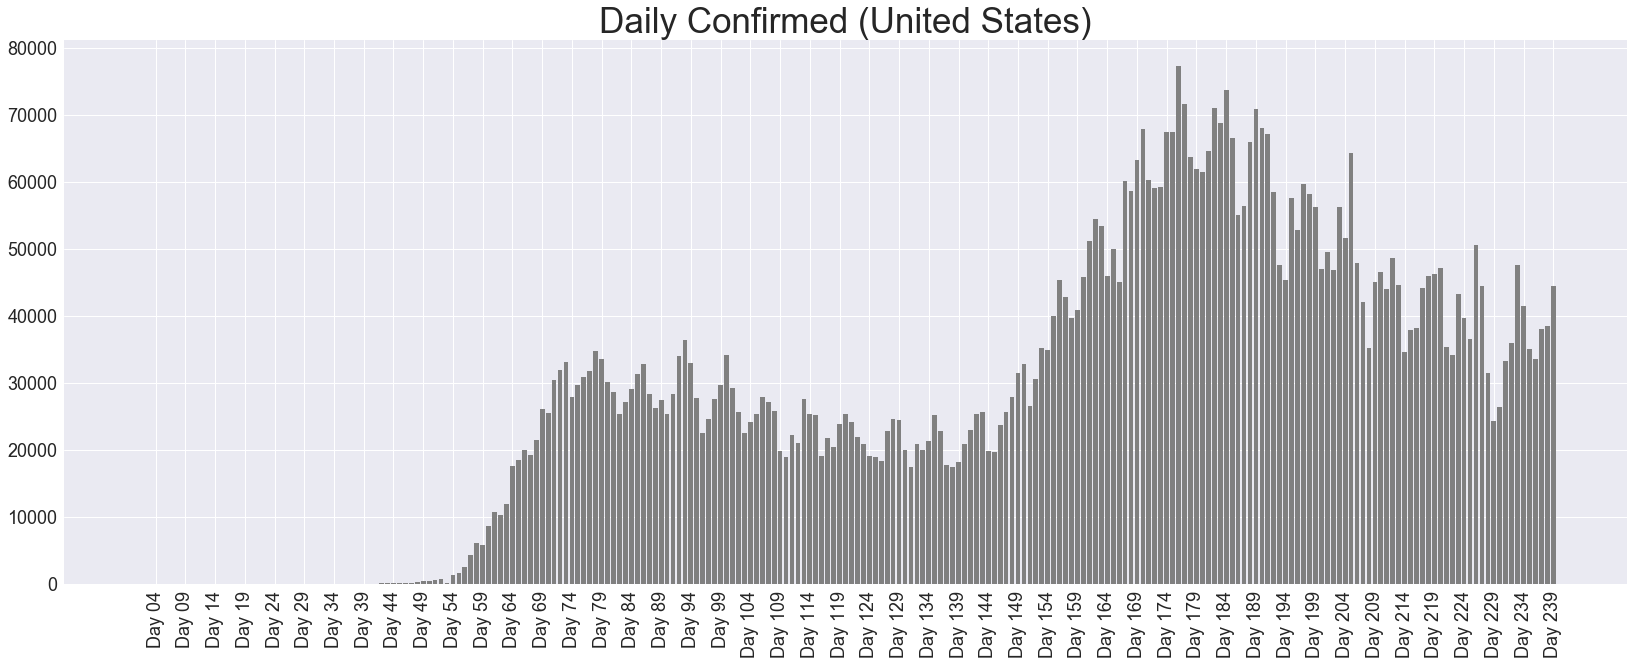

In [21]:
tdf = dfConfGlobal[dfConfGlobal['Country/Region']=='US']

z0 = [i for i in tdf[theDatesGlobal[:-1]].values[0]]
z1 = [i for i in tdf[theDatesGlobal[1:]].values[0]]

numConf = [i[0]-i[1] for i in zip(z1,z0)]

theDays = ['Day 0'+str(i+1) if (len(str(i+1))==1) else 'Day '+str(i+1) for i in range(len(numConf))]

tks = list(range(len(theDays)))[-1::-5][-1::-1]
lbls = theDays[-1::-5][-1::-1]

plt.figure(figsize=[28,10])
plt.bar(theDays, numConf, color='grey')
plt.xticks(ticks=tks, labels=lbls, rotation=90, fontsize=18)
plt.yticks(rotation=0, fontsize=18)
plt.title('Daily Confirmed (United States)', fontsize=35)
plt.show()

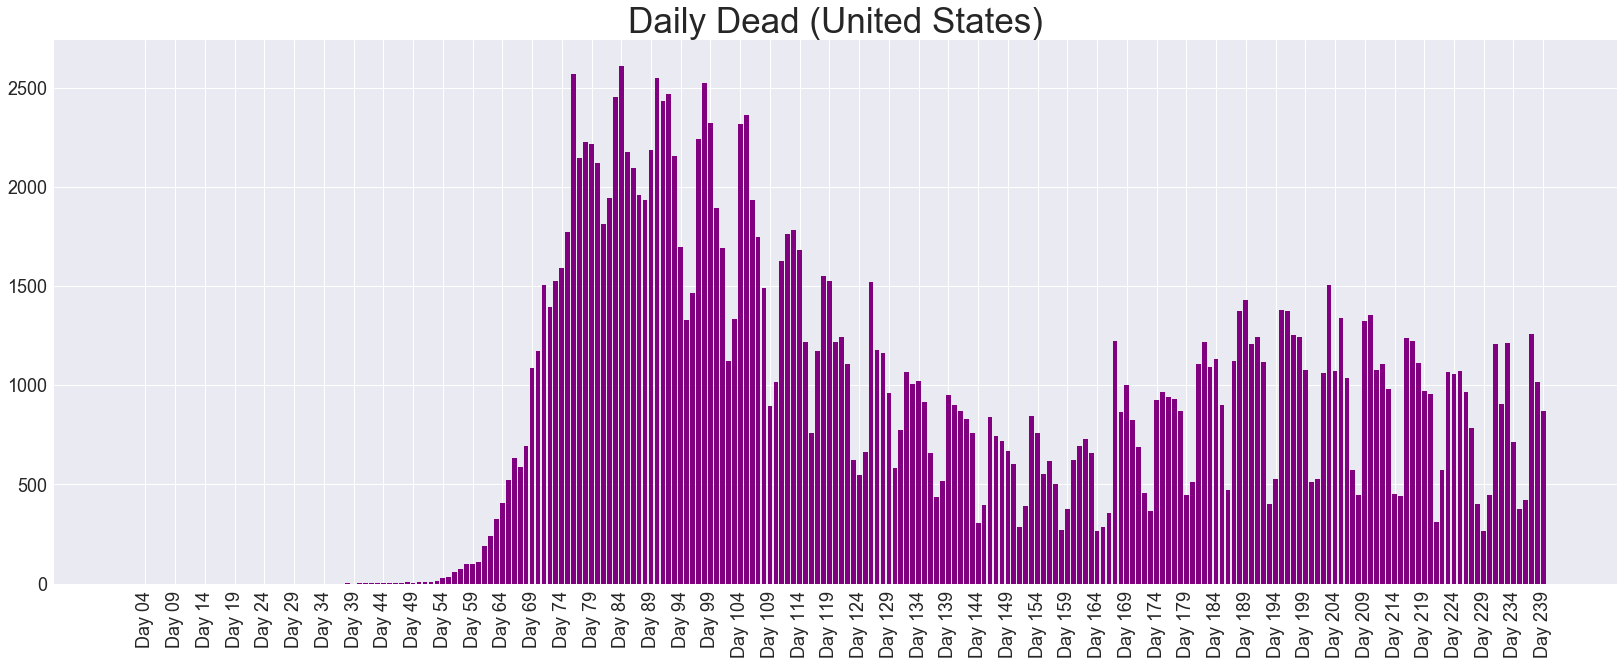

In [22]:
tdf = dfDeadGlobal[dfDeadGlobal['Country/Region']=='US']

z0 = [i for i in tdf[theDatesGlobal[:-1]].values[0]]
z1 = [i for i in tdf[theDatesGlobal[1:]].values[0]]

numDead = [i[0]-i[1] for i in zip(z1,z0)]

theDays = ['Day 0'+str(i+1) if (len(str(i+1))==1) else 'Day '+str(i+1) for i in range(len(numDead))]

tks = list(range(len(theDays)))[-1::-5][-1::-1]
lbls = theDays[-1::-5][-1::-1]

plt.figure(figsize=[28,10])
plt.bar(theDays, numDead, color='purple')
plt.xticks(ticks=tks, labels=lbls, rotation=90, fontsize=18)
plt.yticks(rotation=0, fontsize=18)
plt.title('Daily Dead (United States)', fontsize=35)
plt.show()

In [23]:
# snapshot of the last 5 days in the US

z1 = pd.to_datetime(dfConfUS.columns[-5:])
z1 = [getFullDate(i) for i in z1]

z2 = numConf[-5:]

z3 = numDead[-5:]

indexDays = [(str(5-i)+' Days Ago') if (5-i)>1 else (str(5-i)+' Day Ago') for i in range(len(z3))]

pd.DataFrame(zip(z1,z2,z3), columns=['Date','Confirmed','Dead'], index=indexDays)

,Date,Confirmed,Dead
5 Days Ago,"Sun, Sep 13 2020",34999,378
4 Days Ago,"Mon, Sep 14 2020",33530,422
3 Days Ago,"Tue, Sep 15 2020",37989,1256
2 Days Ago,"Wed, Sep 16 2020",38410,1014
1 Day Ago,"Thu, Sep 17 2020",44360,870


In [24]:
# what percentage of confirmed global CASES and DEATHS does USA represent ?

mostRecentDate1 = dfConfGlobal.columns[-1]
cglob = dfConfGlobal[mostRecentDate1].sum()

mostRecentDate2 = dfConfUS.columns[-1]
cusa = dfConfUS[mostRecentDate2].sum()

mostRecentDate3 = dfDeadGlobal.columns[-1]
dglob = dfDeadGlobal[mostRecentDate3].sum()

mostRecentDate4 = dfDeadUS.columns[-1]
dusa = dfDeadUS[mostRecentDate4].sum()

if (mostRecentDate1 == mostRecentDate2 == mostRecentDate3 == mostRecentDate4):
    print('\nSUCCESS: The dates all match up\n')
else:
    print('\nERROR: The dates do NOT match up\n')

cStr = str(round(100*cusa/cglob, 1))+'%'
dStr = str(round(100*dusa/dglob, 1))+'%'

comp_Global_vs_US = [(cglob, cusa, cStr), (dglob, dusa, dStr)]

pd.DataFrame(comp_Global_vs_US, columns=['Global', 'US', 'Percentage'], index=['Confirmed', 'Dead'])


SUCCESS: The dates all match up



,Global,US,Percentage
Confirmed,30175313,6674411,22.1%
Dead,946061,197633,20.9%


In [25]:
stateConfRes = []

for state in set(dfConfUS['Province_State']):
    
    qdf = dfConfUS.copy()
    rdf = dfDeadUS.copy()
    
    idx = [True if i==state else False for i in qdf['Province_State']]
    qdf = qdf[idx]
    
    idx = [True if i==state else False for i in rdf['Province_State']]
    rdf = rdf[idx]
    
    checkColQ = qdf.columns[-1]
    ss = qdf[checkColQ].sum()
    
    checkColR = qdf.columns[-1]
    tt = rdf[checkColR].sum()
    
    if ss!=0:
        pctDead = round(100*tt/ss,1)
    else:
        pctDead = 0
        
    if checkColQ!=checkColR:
        print('\n\n\nWARNING: Reports dates are different for '+Style.BRIGHT+state+Style.RESET_ALL+'\n\n')
        
    stateConfRes.append( (state,ss,tt,pctDead) )

stateConfRes = sorted(stateConfRes, key=lambda x:x[1], reverse=True) # sort by cases
# stateConfRes = sorted(stateConfRes, key=lambda x:x[2], reverse=True) # sort by dead

stateConfRes = pd.DataFrame(stateConfRes, columns=['State', 'Cases', 'Dead', 'Pct_Dead'])

stateConfRes

,State,Cases,Dead,Pct_Dead
0,California,775037,14804,1.9
1,Texas,701350,14826,2.1
2,Florida,674456,13086,1.9
3,New York,447262,33070,7.4
4,Georgia,300903,6474,2.2
5,Illinois,270294,8624,3.2
6,Arizona,211660,5409,2.6
7,New Jersey,198361,16057,8.1
8,North Carolina,189576,3180,1.7
9,Tennessee,178140,2164,1.2
